In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
from PIL import Image
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore') 

In [2]:
!git clone https://github.com/Sibasis555/CT_SCAN_COVID.git

Cloning into 'CT_SCAN_COVID'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [3]:
from zipfile import ZipFile
file_name='/content/CT_SCAN_COVID/CT_COVID.zip'
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.extractall('photos')
    print('done') 

from zipfile import ZipFile
file_name='/content/CT_SCAN_COVID/CT_NonCOVID.zip'
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.extractall('photos')
    print('done')

done
done


In [ ]:
root = '/content/photos/'
os.makedirs(root +'/train/case+')
os.makedirs(root +'/train/case-')
os.makedirs(root +'/val/case+')
os.makedirs(root +'/val/case-')
os.makedirs(root +'/test/case+')
os.makedirs(root +'/test/case-')

In [ ]:
currentCls = '/case+'
src = "/content/photos/CT_COVID" # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])
train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/photos/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, "/content/photos/val"+currentCls)

for name in test_FileNames:
    shutil.copy(name, "/content/photos/test"+currentCls)

Total images:  349
Training:  244
Validation:  52
Testing:  53


In [ ]:
currentCls = '/case-'
src = "/content/photos/CT_NonCOVID" # Folder to copy images from

torch.manual_seed(42)

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/photos/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, "/content/photos/val"+currentCls)

for name in test_FileNames:
    shutil.copy(name, "/content/photos/test"+currentCls)

Total images:  397
Training:  277
Validation:  60
Testing:  60


In [ ]:
train_transform=transforms.Compose([
                              transforms.RandomRotation(10),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize(224),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_transform=transforms.Compose([
                                   transforms.Resize(224),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [ ]:
train_data=datasets.ImageFolder('/content/photos/train',transform=train_transform)
test_data=datasets.ImageFolder('/content/photos/test',transform=test_transform)
val_data=datasets.ImageFolder('/content/photos/val',transform=test_transform)
class_name=train_data.classes
class_name

['case+', 'case-']

In [ ]:
len(test_data)

113

In [ ]:
train_loader=DataLoader(train_data,batch_size=40,shuffle=True)
test_loader=DataLoader(test_data,batch_size=8)
val_loader=DataLoader(val_data,batch_size=8)

In [ ]:
seed=0
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

## **Model Creation**

In [ ]:
model = models.vgg19(pretrained=True) # we will use a pretrained model and we are going to change only the last layer

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for p in model.parameters():
    print(p.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
from collections import OrderedDict

model.classifier = nn.Sequential(OrderedDict([
                                            #('fcl1', nn.Linear(2048,256)),
                                           #('dp1', nn.Dropout(0.5)),
                                           #('r1', nn.ReLU()),
                                           ('fcl1', nn.Linear(25088,256)),
                                           ('dp1', nn.Dropout(0.5)),
                                           ('r', nn.ReLU()),
                                            ('fcl2', nn.Linear(256,2))
                                           #('out', nn.LogSoftmax(dim=1)),
]))

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model=model.cuda()

In [ ]:
'''criterion = nn.NLLLoss()
optimizer = torch.optim.Adadelta(model.parameters())'''
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=0.001)

## **Training model**

In [ ]:
import time
start_time=time.time()

epochs=60
train_losses=[]
train_correct=[]
trn_per=[]
val_per=[]
y_pred=[]
y_true=[]
val_correct=[]
val_losses=[]
for i in range(epochs):
  trn_corr=0
  for b,(x_train,y_train) in enumerate(train_loader):
    #optional limit number of batches
    if torch.cuda.is_available():
       x_train, y_train = x_train.cuda(), y_train.cuda()
    b+=1
    y_pred=model(x_train)
    loss=criterion(y_pred,y_train)
    
    #Tally the number of correct prediction
    predicted=torch.max(y_pred.data,1)[1]
    batch_corr=(predicted==y_train).sum()
    trn_corr+=batch_corr
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print updates
    if b%13 == 0:
      print(f'Epoch {i:2} batch:{b:4} [{40*b:6}/521] Loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(40*b):7.3f}%')
  train_losses.append(loss)
  total_per=trn_corr.item()/521*100
  train_correct.append(total_per)

  with torch.no_grad():
    val_corr=0
    for b,(x_valid,y_valid) in enumerate(val_loader):
      #Optional
      if torch.cuda.is_available():
         x_valid, y_valid = x_valid.cuda(), y_valid.cuda()
      '''if b==max_tst_batch:
        break'''
      b=b+1  
      y_val =model(x_valid)
      loss=criterion(y_val,y_valid)
      predicted=torch.max(y_val.data,1)[1]
      batch_corr=(predicted==y_valid).sum()
      val_corr+=batch_corr
      if b%14==0:
        print(f'Loss: {loss.item():10.8f} , accuracy: {val_corr.item()/(b*8)*100:7.3f}%')
    val_losses.append(loss)
    total_per=val_corr.item()/112*100
    val_correct.append(total_per)
total_time=time.time() - start_time
print(f'Total time: {total_time/60} minutes')

Epoch  0 batch:  13 [   520/521] Loss: 1.29599166  accuracy:  56.923%
Loss: 0.27671823 , accuracy:   6.250%
Epoch  1 batch:  13 [   520/521] Loss: 0.72095382  accuracy:  69.615%
Loss: 0.03928826 , accuracy:   7.143%
Epoch  2 batch:  13 [   520/521] Loss: 0.53942126  accuracy:  75.192%
Loss: 0.24452782 , accuracy:   5.357%
Epoch  3 batch:  13 [   520/521] Loss: 0.33938235  accuracy:  80.962%
Loss: 0.56801575 , accuracy:   5.357%
Epoch  4 batch:  13 [   520/521] Loss: 0.34266770  accuracy:  84.231%
Loss: 0.70734692 , accuracy:   5.357%
Epoch  5 batch:  13 [   520/521] Loss: 0.53865057  accuracy:  84.615%
Loss: 0.70035011 , accuracy:   4.464%
Epoch  6 batch:  13 [   520/521] Loss: 0.23784046  accuracy:  84.615%
Loss: 0.42313623 , accuracy:   5.357%
Epoch  7 batch:  13 [   520/521] Loss: 0.32215202  accuracy:  88.462%
Loss: 0.78671974 , accuracy:   5.357%
Epoch  8 batch:  13 [   520/521] Loss: 0.18462655  accuracy:  88.462%
Loss: 0.39063123 , accuracy:   5.357%
Epoch  9 batch:  13 [   520/

### **Test set**

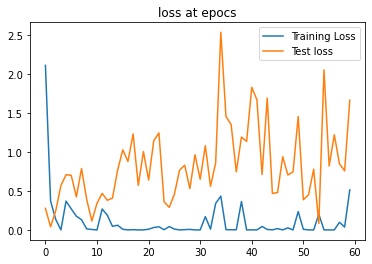

In [ ]:
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Test loss')
#plt.plot(val_losses,label='validation loss')
plt.title('loss at epocs')
plt.legend()

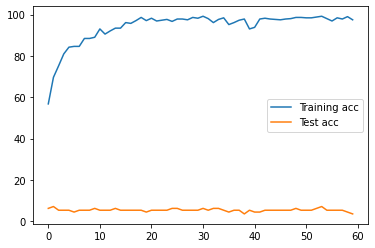

In [ ]:
plt.plot(train_correct,label='Training acc')
plt.plot(val_correct,label='Test acc')
#plt.plot(val_correct,label='val acc')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

In [ ]:
#Test set
y_tst_pred=[]
y_tst_true=[]
test_losses=[]
test_correct=[]
with torch.no_grad():
    tst_corr=0
    for b,(x_test,y_test) in enumerate(test_loader):
      #Optional
      if torch.cuda.is_available():
         x_test,y_test = x_test.cuda(), y_test.cuda()
      '''if b==max_tst_batch:
        break'''
      b=b+1
      y_val =model(x_test)
      loss=criterion(y_val,y_test)
      predicted=torch.max(y_val.data,1)[1]
      tst_corr+=(predicted==y_test).sum()
      y_tst_pred.append(predicted.cpu().numpy())
      y_tst_true.append(y_test.cpu().numpy())
      if b%14==0:
        print(f'Loss: {loss.item():10.8f} , accuracy: {tst_corr.item()/(8*b)*100:7.3f}%')
    test_losses.append(loss)
    test_correct.append(tst_corr)

Loss: 0.44241109 , accuracy:  82.143%


In [ ]:
y_tst_pred

[array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 1, 1]),
 array([0, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 1, 1, 1, 1, 0, 1]),
 array([0, 1, 1, 1, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 1, 1, 0, 1]),
 array([1, 1, 0, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 0, 1]),
 array([0, 1, 1, 1, 1, 0, 1, 1]),
 array([0])]

In [ ]:
y_tst_pred=np.array(y_tst_pred)
#x_pred=x_pred.reshape(1,-1)
y_tst_pred=np.hstack(y_tst_pred).tolist()
y_tst_pred=np.array(y_tst_pred)
#sns_test_pred=sns_test_pred.astype(int)
y_tst_true=np.array(y_tst_true)
#x_true=x_true.reshape(1,-1)
y_tst_true=np.hstack(y_tst_true).tolist()
y_tst_true=np.array(y_tst_true)

#sns_test_y=sns_test_y.astype(int)
y_tst_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0])

In [ ]:
y_tst_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

**sensitivity = recall = tp / t = tp / (tp + fn),
specificity = tn / n = tn / (tn + fp),
precision = tp / p = tp / (tp + fp),
F1 Score=**

In [ ]:
print("Accuracy score: \n",accuracy_score(y_tst_true,y_tst_pred))
print("Confusion Matrix: \n",confusion_matrix(y_tst_true,y_tst_pred))
print("Classification report: \n",classification_report(y_tst_true,y_tst_pred))

Accuracy score: 
 0.8141592920353983
Confusion Matrix: 
 [[48  5]
 [16 44]]
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.91      0.82        53
           1       0.90      0.73      0.81        60

    accuracy                           0.81       113
   macro avg       0.82      0.82      0.81       113
weighted avg       0.83      0.81      0.81       113



In [ ]:
fpr,tpr,thresholds=roc_curve(y_tst_true,y_tst_pred)
plt.plot(fpr,tpr,color='green')

In [ ]:
roc_auc_score(y_true,y_pred)

In [ ]:
torch.save(model.state_dict(),'COVID-19(80-85).pt')

In [ ]:
'''from google.colab import files
uploaded=files.upload()'''

In [ ]:
'''im=plt.imread('carona19.jpg')
image=Image.open('carona19.jpg').convert('RGB')
x=test_transform(image)
x=x.unsqueeze(0)
x=x.cuda()'''